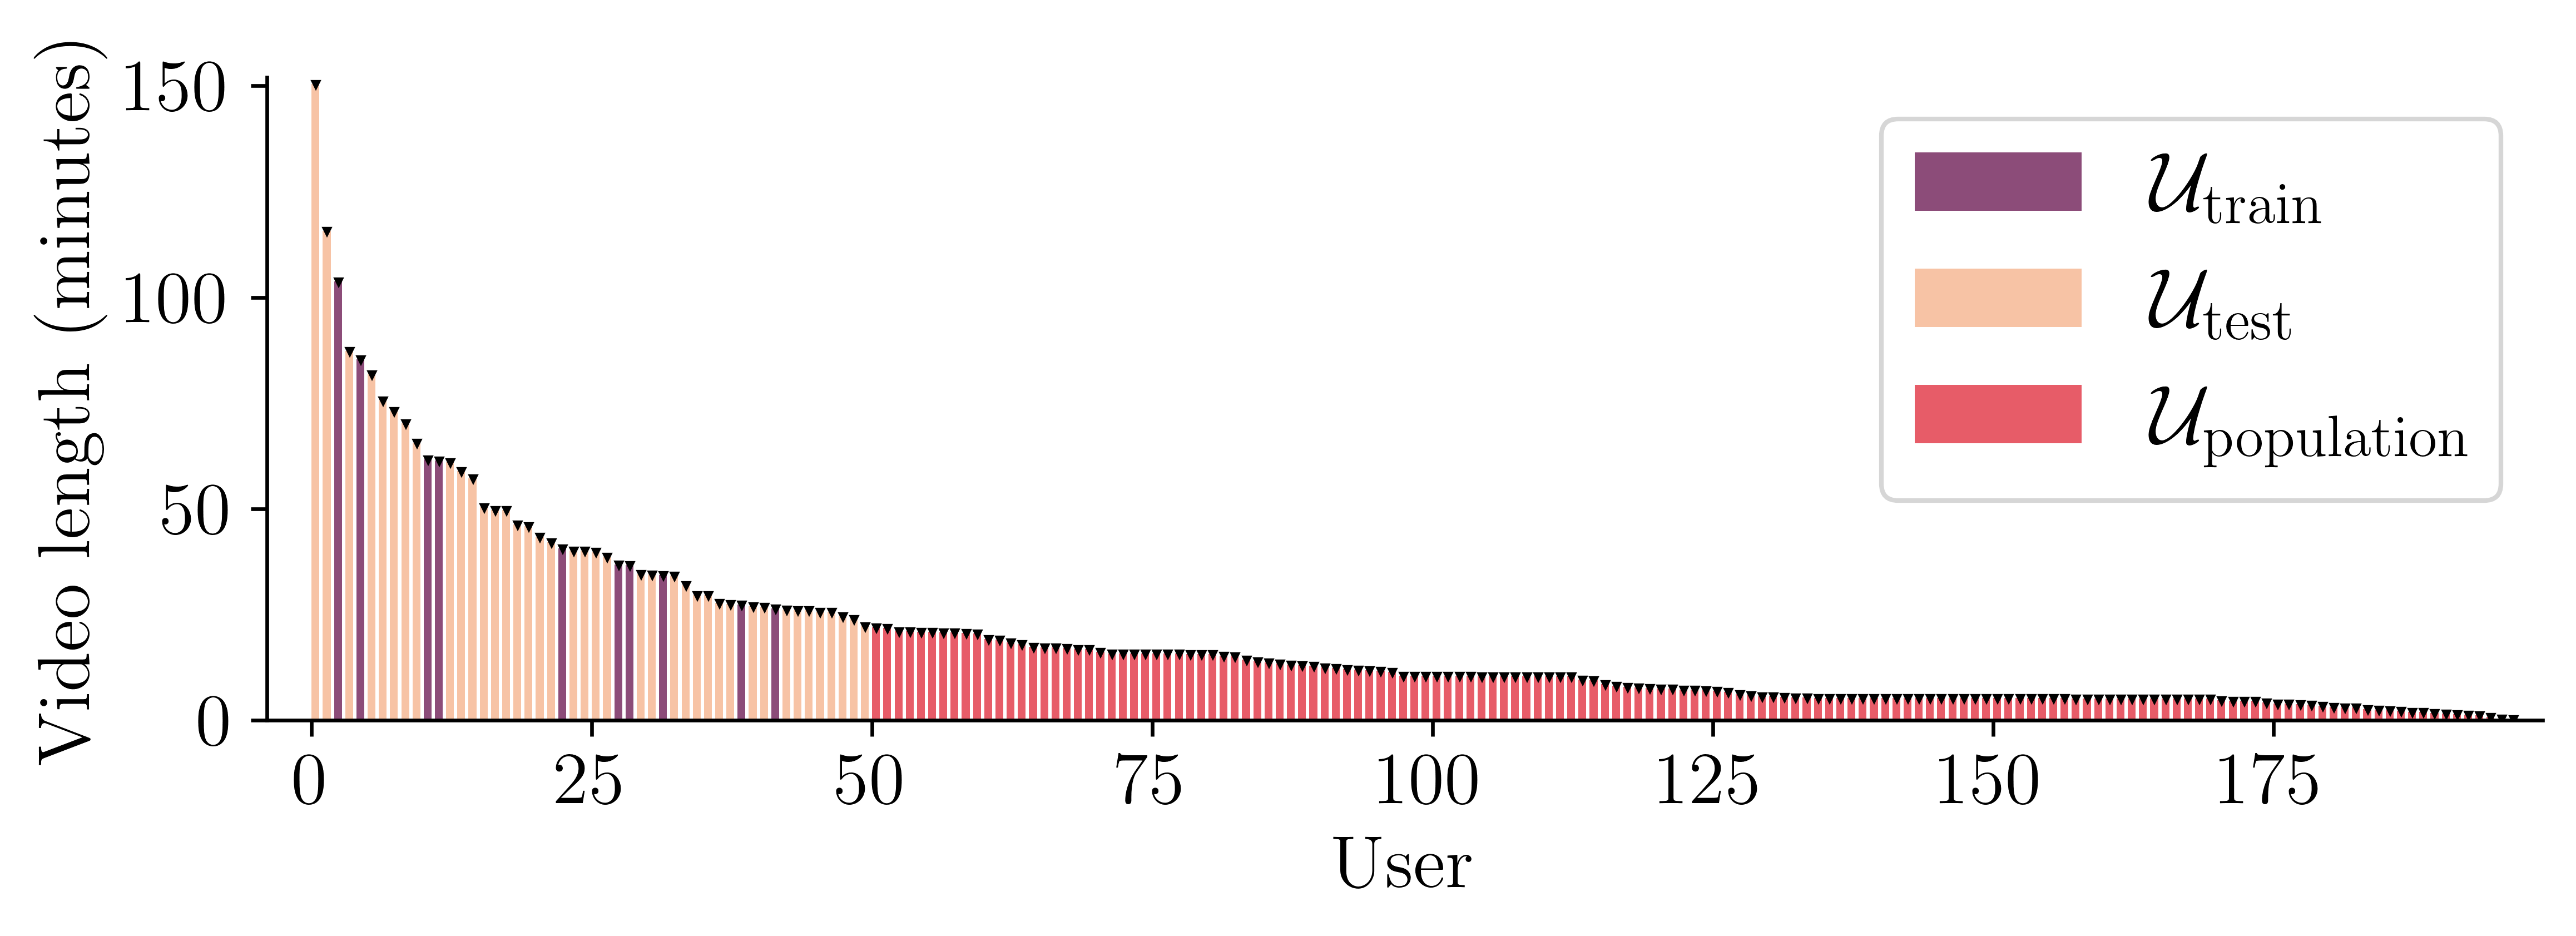

<Figure size 432x288 with 0 Axes>

In [12]:
""" Split in train and test sets and generate summary. """

import pandas as pd
import numpy as np
from collections import Counter
import os.path as osp
import json
import matplotlib.pyplot as plt
import argparse
import datetime
import os
from collections import defaultdict
import sys
import seaborn as sns

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 16
# plt.rcParams.update(**font)

# Use latex in mpl
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}' #for \text command

parser = argparse.ArgumentParser(description="User split for ego4d LTA task.")
parser.add_argument(
    "--nb_users_thresh",
    help="Number users to keep as subset",
    default=50,
    type=int,
)
parser.add_argument(
    "--nb_users_train",
    help="Number users to use for training, should be <= nb_users_thresh."
         "The 'nb_users_thresh - nb_users_train' are used for testing.",
    default=10,
    type=int,
)

parser.add_argument(
    "--usersplit_criterion",
    help="Criterion to split the users on",
    default='random',
    choices=['random', 'time_weighed'],
    type=str,
)

parser.add_argument(
    "--user_videotime_min_thresh",
    help="Number of videominutes users need to remain in the subset",
    default=None,
    type=int,
)
parser.add_argument(
    "--sort_by_col",
    help="Column in dataframe to sort on. (Default: total sum of user clip-video length)",
    default="sum_clip_duration_min",
    type=str,
)
parser.add_argument(
    "--p_output_dir",
    help="Parent dir to output timestamped dir including plots and json splits.",
    default="../imgs/notebooks_new",
    type=str,
)
parser.add_argument(
    "--seed",
    help="Seed numpy for deterministic splits",
    default=0,
    type=int,
)


# Write both to file and stdout
class Logger(object):
    def __init__(self, filename="Default.log"):
        self.terminal = sys.stdout
        self.log = open(filename, "a")

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)

    def flush(self):
        self.log.flush()


def generate_usersplit_from_trainval(
        meta_data_file_path: str,
        train_annotation_file: str,
        val_annotation_file: str,
        user_id_col="fb_participant_id"):
    """ Get mini-train, test, and pretrain data splits."""

    args = parser.parse_args(args=[])
    nb_users_test = args.nb_users_thresh - args.nb_users_train
    train_ratio = args.nb_users_train / args.nb_users_thresh
    np.random.seed(args.seed)

    # Paths and logger
    # Check outdir path
    now = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    output_dir = osp.join(args.p_output_dir, f"{now}_ego4d_LTA_usersplit")
    os.makedirs(output_dir, exist_ok=True, mode=0o777)
    sys.stdout = Logger(osp.join(output_dir, "logger_dump.txt"))

    # check args
    assert args.nb_users_thresh is None or args.user_videotime_min_thresh is None, \
        "Can only define one thresholding method!"

    # Open meta data object
    with open(meta_data_file_path, 'r') as meta_data_file:
        meta_data_obj = json.load(meta_data_file)
    meta_df = pd.json_normalize(meta_data_obj['videos'])
    print(f"meta_data.shape={meta_df.shape}")

    # Open train and val objects
    with open(train_annotation_file, 'r') as train_file, \
            open(val_annotation_file, 'r') as val_file:
        train_clips = json.load(train_file)['clips']
        val_clips = json.load(val_file)['clips']

    train_clips_df = pd.json_normalize(train_clips)
    val_clips_df = pd.json_normalize(val_clips)
    print(f"trainshape={train_clips_df.shape}, valshape={val_clips_df.shape}")

    # Show overlapping
    print(f"Meta colnames={list(meta_df)}")
    print(f"Annotation colnames={list(train_clips_df)}")
    overlapping_colnames = [x for x in list(meta_df) if x in list(train_clips_df)]
    print(f"Overlapping colnames={overlapping_colnames}")

    # MERGE dataframes on video_uid (Right join: keep annotation entries, but add video_uid info)
    train_joined_df = pd.merge(meta_df, train_clips_df,
                               on="video_uid", validate="one_to_many", how="right")
    val_joined_df = pd.merge(meta_df, val_clips_df,
                             on="video_uid", validate="one_to_many", how="right")
    print(f"train_joined_df={train_joined_df.shape}, val_joined_df={val_joined_df.shape}")

    # CONCAT the dataframes (312 rows × 12 columns)
    trainval_joined_df = pd.concat([train_joined_df, val_joined_df], ignore_index=True, sort=False)

    # FIND USERS that satisfy video-length threshold
    # Note: video_uid relates to the entire uncut raw video,
    # these are split into ~5-min clips, denoted with clip_id for the annotations.
    trainval_user_df, nan_user_df = summarize_clips_by_user(trainval_joined_df)

    # Sort users on sum_length
    trainval_user_df = trainval_user_df.sort_values(by=[args.sort_by_col], ascending=False)

    pretrain_user_ids = []
    pretrain_sort_values = []
    # Keep only highest in sorted
    if args.nb_users_thresh is not None:
        print(f"Thresholding on nb_users_thresh")
        sorted_user_ids = trainval_user_df[: args.nb_users_thresh][user_id_col].tolist()
        user_sort_values = trainval_user_df[: args.nb_users_thresh][args.sort_by_col].tolist()

        # PRETRAIN: Leftover users + NaN user
        pretrain_user_ids = trainval_user_df[args.nb_users_thresh:][user_id_col].tolist()
        pretrain_sort_values = trainval_user_df[args.nb_users_thresh:][args.sort_by_col].tolist()

        # Add NaN user
        pretrain_user_ids.append(None)
        pretrain_sort_values.extend(nan_user_df[args.sort_by_col].tolist())

    elif args.user_videotime_min_thresh is not None:
        raise NotImplementedError("Not supporting this split")
        print(f"Thresholding on user_videotime_min_thresh")
        user_subset_df = trainval_user_df.loc[trainval_user_df[args.sort_by_col] >= args.user_videotime_min_thresh]
        sorted_user_ids = user_subset_df[user_id_col].tolist()
        user_sort_values = user_subset_df[args.sort_by_col].tolist()

    else:  # No cutoff
        print(f"No thresholding = no pretrain data")
        sorted_user_ids = trainval_user_df[user_id_col].tolist()
        user_sort_values = trainval_user_df[args.sort_by_col].tolist()

    # Get train/test splits from train/val datasets
    if args.usersplit_criterion == 'random':
        shuffled_idxs = np.random.permutation(np.arange(len(sorted_user_ids)))
        train_idxs, test_idxs = shuffled_idxs[:args.nb_users_train], shuffled_idxs[args.nb_users_train:]

    elif args.usersplit_criterion == 'time_weighed':
        raise NotImplementedError()
    else:
        raise ValueError()

    sorted_user_ids, user_sort_values = np.array(sorted_user_ids), np.array(user_sort_values)
    train_user_ids, test_user_ids = sorted_user_ids[train_idxs], sorted_user_ids[test_idxs]
    train_sort_values, test_sort_values = user_sort_values[train_idxs], user_sort_values[test_idxs]

    # Print summary
    nb_traintest_users_subset = len(sorted_user_ids)
    nb_train_users_subset = len(train_user_ids)
    nb_test_users_subset = len(test_user_ids)
    nb_pretrain_users_subset = len(pretrain_user_ids)
    nb_total_users = nb_pretrain_users_subset + nb_traintest_users_subset

    print_summary(user_sort_values, nb_traintest_users_subset, nb_total_users, "Train+Test user subset")
    print_summary(train_sort_values, nb_train_users_subset, nb_traintest_users_subset, "Train user subset")
    print_summary(test_sort_values, nb_test_users_subset, nb_traintest_users_subset, "Test user subset")
    print_summary(pretrain_sort_values, nb_pretrain_users_subset, nb_total_users, "Pretrain user subset")

    # Summary plot (pdf?)
    ylabel = 'Video length (minutes)'
    xlabel = "User"
    title = "Sum of clip video lengths (min) per user"

    # Get colors for train+test summary plot
    labels = [r'$\mathcal{U}_\text{train}$', r'$\mathcal{U}_\text{test}$']
    include_nan_pretrain = False
    bar_colors =[ sns.color_palette("rocket")[1], sns.color_palette("rocket")[5]]
    y_axis = [list(train_sort_values), list(test_sort_values)]
    x_axis = [train_idxs, test_idxs]
    if len(pretrain_sort_values) > 0:
        x_offset = nb_traintest_users_subset
        
        if include_nan_pretrain:
            y_axis.append(list(pretrain_sort_values))
            x_axis.append([idx for idx in range(x_offset, x_offset + len(pretrain_sort_values))])
        else:
            y_axis.append(list(pretrain_sort_values[:-1]))
            x_axis.append([idx for idx in range(x_offset, x_offset + len(pretrain_sort_values)-1)])
        bar_colors.append(sns.color_palette("rocket")[3])
        labels.append(r'$\mathcal{U}_\text{population}$')
    plot_tag = 'TRAIN_TEST_PRETRAIN'
    plot_barchart(x_axis, y_axis, title=f'{plot_tag} {title}', ylabel=ylabel, legend_labels=labels,
                  xlabel=xlabel,
                  bar_colors=bar_colors, output_file=osp.join(output_dir, f'{plot_tag}_video_freq_plot.pdf'))

#     y_axis = sorted(train_sort_values, reverse=True)
#     x_axis = [idx for idx in range(len(train_sort_values))]
#     plot_tag = 'TRAIN'
#     plot_barchart([x_axis], [y_axis], title=f'{plot_tag} {title}', ylabel=ylabel, xlabel=xlabel,
#                   output_file=osp.join(output_dir, f'{plot_tag}_video_freq_plot.pdf'))

#     y_axis = sorted(test_sort_values, reverse=True)
#     x_axis = [idx for idx in range(len(test_sort_values))]
#     plot_tag = 'TEST'
#     plot_barchart([x_axis], [y_axis], title=f'{plot_tag} {title}', ylabel=ylabel, xlabel=xlabel,
#                   output_file=osp.join(output_dir, f'{plot_tag}_video_freq_plot.pdf'))

#     y_axis = sorted(pretrain_sort_values, reverse=True)
#     x_axis = [idx for idx in range(len(pretrain_sort_values))]
#     plot_tag = 'PRETRAIN'
#     plot_barchart([x_axis], [y_axis], title=f'{plot_tag} {title}', ylabel=ylabel, xlabel=xlabel,
#                   output_file=osp.join(output_dir, f'{plot_tag}_video_freq_plot.pdf'))





def add_action_columns(df):
    def label_fn(x):
        assert len(x) == 2, "Need two columns to merge"
        if not isinstance(x[0], list):
            assert not isinstance(x[1], list)
            return f"{x[0]}-{x[1]}"

        return [f"{l}-{r}" for l, r in zip(x[0], x[1])]

    df['action_label'] = df.loc[:, ('verb_label', 'noun_label')].apply(label_fn, axis=1)
    df['action'] = df.loc[:, ('verb', 'noun')].apply(label_fn, axis=1)


def print_summary(user_sort_values, nb_users_subset, nb_total_users, title: str):
    print(f"\n{'*' * 20} SUMMARY: {title} {'*' * 20}")
    print(f"Retaining a total of {nb_users_subset} / {nb_total_users} users")
    print(f"SUM = {sum(user_sort_values)}")
    print(f"MAX = {max(user_sort_values)}, MIN = {min(user_sort_values)}")
    print(f"HEAD = {user_sort_values[:10]}...")
    print(f"TAIL = ...{user_sort_values[-10:]}")
    print(f"{'*' * 50}")


def summarize_clips_by_user(joined_df):
    """Group annotation entries by clip_uid, then group those unique clips by user."""
    clip_df = joined_df.groupby(joined_df['clip_uid'], as_index=False).agg(
        {'fb_participant_id': lambda x: np.unique(x).tolist(),
         'scenarios': list,
         'verb': list, 'noun': list, 'verb_label': list, 'noun_label': list, 'action_idx': list,
         #          'video_uid':list,'duration_sec':list, # This is the raw uncut video, don't need this info
         'clip_id': list, 'clip_parent_start_sec': lambda x: np.unique(x).tolist(),
         'clip_parent_end_sec': lambda x: np.unique(x).tolist()})

    # Check users/clip_starts and ends are only 1 unique
    assert (clip_df.fb_participant_id.apply(len) == 1).all()
    assert (clip_df.clip_parent_start_sec.apply(len) == 1).all()
    assert (clip_df.clip_parent_end_sec.apply(len) == 1).all()

    # Unpack
    for col_name in ['fb_participant_id', 'clip_parent_start_sec', 'clip_parent_end_sec']:
        clip_df[col_name] = clip_df[col_name].apply(lambda x: x[0])

    # Get actual clip lengths in seconds (~5min=300s)
    clip_df['clip_duration_sec'] = clip_df.loc[:, ('clip_parent_end_sec', 'clip_parent_start_sec')].apply(
        lambda x: x[0] - x[1], axis=1)

    # Group by fb_participant_id, which has allocated multiple 5min clips (unique clip_uid's)
    user_df = clip_df.groupby(clip_df['fb_participant_id'], as_index=False, dropna=False).agg(  # NaN Dropped by default
        {
            'scenarios': list,
            'verb': list, 'noun': list, 'verb_label': list, 'noun_label': list, 'action_idx': list,
            'clip_id': list, 'clip_parent_start_sec': list, 'clip_parent_end_sec': list, 'clip_duration_sec': list}
    )

    # Sum clip lengths per user
    user_df['sum_clip_duration_sec'] = user_df['clip_duration_sec'].apply(sum)
    user_df['sum_clip_duration_min'] = user_df['sum_clip_duration_sec'].apply(lambda x: x / 60)

    # The scenarios only apply to the raw uncut video, not the 5min clips
    user_df = user_df.rename(columns={"scenarios": "possible_clip_scenarios"})

    # Extract NaN user entry
    nan_user_df = user_df[user_df.fb_participant_id.isnull()]
    user_df = user_df[user_df.fb_participant_id.notnull()]

    # Check that no NaN user for valid users
    assert not (user_df['fb_participant_id'].isna().any())

    return user_df, nan_user_df


def plot_barchart(x_axis: list[list], y_vals: list[list], title, ylabel, xlabel, y_labels=None, x_labels=None,
                  legend_labels=None,
                  grid=False, yerror: list[list] = None, bar_align='edge', bar_colors=None,
                  figsize=(8, 3), log=False, interactive=False, x_minor_ticks=None, output_file=None):
    max_val = max(el for y_l in y_vals for el in y_l)
    my_cmap = plt.get_cmap("plasma")
    fig = plt.figure(figsize=figsize, dpi=600)  # So all bars are visible!
    ax = plt.subplot()

    for plot_idx, (x, y) in enumerate(zip(x_axis, y_vals)):
        plot_yerror = None if yerror is None else yerror[plot_idx]
        bar_color = my_cmap.colors if bar_colors is None else bar_colors[plot_idx]
        legend_label = None if legend_labels is None else legend_labels[plot_idx]
        plt.bar(x, height=y, yerr=plot_yerror, label=legend_label,
                color=bar_color, align=bar_align, width=0.7, log=log,
                alpha=0.8
#                linewidth=0.1,edgecolor='white'
               )
        
        x_center = [el+0.4 for el in x]
        plt.plot(x_center, y, marker="v",markersize=0.8,
                 linestyle="", alpha=1, color="black")

    if legend_labels is not None:
        plt.legend(prop={'size': 18})


    if x_minor_ticks is not None:
        #         ax.set_xticks(major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
    #         ax.set_yticks(major_ticks)
    #         ax.set_yticks(minor_ticks, minor=True)

    # And a corresponding grid
    #         ax.grid(which='both')

    #         # Or if you want different settings for the grids:
    #         ax.grid(which='minor', alpha=0.2)
    #         ax.grid(which='major', alpha=0.5)
    
    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    if x_labels:
        plt.xticks(x_axis, x_labels, rotation='vertical')
    if y_labels:
        plt.yticks(y_vals, y_labels)

    plt.ylim(None, max_val * 1.01)
    plt.xlim(-4, 199)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    print(title)
#     plt.title(title)
    plt.grid(grid, which='both')
    


    # Save
    fig.tight_layout()
    if output_file is not None:
        fig.savefig(output_file, bbox_inches='tight')
        print(f"Saved plot: {output_file}")

    plt.show()
    plt.clf()


def df_to_per_user_formatted_json(df, user_id_list, split, user_id_col_name):
    """Convert to a json with at
    L1: users, split
    L2: per user parse the annotation entries.

    if user_id_list contains None, we translate it too look for NaN values.
    """
    result = {'users': defaultdict(list), 'split': split}

    for user_id in user_id_list:  # iterate users
        parsed_user_id = int(float(user_id)) if user_id is not None else user_id  # 104.0 -> 104 in JSON

        if user_id is None:
            user_df = df.loc[df[user_id_col_name].isna()]
            print(f"JSON includes NAN user, len={len(user_df)}")
        else:
            user_df = df.loc[df[user_id_col_name] == user_id]
            print(f"JSON includes user {user_id}, len={len(user_df)}")

        for _, row in user_df.iterrows():  # Iterate annotations for the user
            parsed_row = {}
            for idx, val in row.iteritems():  # Convert col values to dict style
                key = idx
                parsed_row[key] = val

            result['users'][parsed_user_id].append(parsed_row)
    return result



# META DATA
meta_data_file_path = "/fb-agios-acai-efs/Ego4D/ego4d_data/ego4d.json"

# ANNOTATION DATA LTA
annotation_file_dir = "/fb-agios-acai-efs/Ego4D/ego4d_data/v1/annotations"
annotation_file_names = {'train': "fho_lta_train.json", 'val': 'fho_lta_val.json',
                         'test': 'fho_lta_test_unannotated.json'}
train_annotation_file = osp.join(annotation_file_dir, annotation_file_names['train'])
val_annotation_file = osp.join(annotation_file_dir, annotation_file_names['val'])

generate_usersplit_from_trainval(
    meta_data_file_path,
    train_annotation_file,
    val_annotation_file,
)
